# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd
import re
import librosa   
import pickle

In [ ]:
# init_path = 'drive/MyDrive/wav/'
# fs = os.listdir(init_path)
# fs = [init_path + x for x in fs]

In [ ]:
init_path = 'drive/Shareddrives/Ling Thesis/resampled/'
fs = os.listdir(init_path)
fs = [init_path + x for x in fs]

In [ ]:
# with open(fs[0], 'rb') as handle:
#   audio_array = pickle.load(handle)

In [ ]:
  # audio_array, s = librosa.load(f,mono=False)
  # a = audio_array.shape[0]
  # print(a)
  # shapes.append(a)

In [ ]:
def get_boundaries(fpath):
  with open(fpath) as f:
    t = f.read()
  a = t.split('\x15')
  IUs = [x for i,x in enumerate(a) if i%2==1]
  boundaries = [x.split('_') for x in IUs]
  a = []
  for b in boundaries:
    a.append(int(b[0]))
    a.append(int(b[1]))

  boundaries = sorted(list(set(a)))
  boundaries = (np.array(boundaries))/1000
  return boundaries

In [ ]:
text_path = 'drive/Shareddrives/Rezonator Data/SBCSAE/'

In [ ]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [ ]:
# def window_context(arr):
#   x1 = np.mean(arr)
#   x2 = np.std(arr)
#   x3 = np.mean(audio_array>0.005)
#   x4 = np.mean(audio_array>0.002)
#   x5 = np.mean(audio_array>0.001)
#   return [x1,x2,x3,x4,x5]

In [ ]:
def append_feats(t_b):
  R_1 = MFCC[:,int(np.floor((t_b-20000)/32)):int(np.floor((t_b)/32))]
  R_2 = MFCC[:,int(np.floor((t_b)/32)):int(np.floor((t_b+20000)/32))]
  R_3 = MFCC[:,int(np.floor(t_b/32))-156:int(np.floor(t_b/32))+156]
  # R_4 = window_context(abs_array[t_b-20000:t_b+20000])

  X_preboundary.append(R_1)
  X_postboundary.append(R_2[:,::-1])
  X_boundary.append(R_3)
  # X_meta.append(R_4)

In [ ]:
X_preboundary = []
X_postboundary = []
X_boundary = []
# X_meta = []
y = []


for file_index,f in enumerate(fs):
  print(f'{file_index}: {f}')

  # print('\tresample')
  # audio_array, s = librosa.load(f, sr=8000)

  

  # tt = re.findall(r'\d+', f)[0][-2:]
  # with open(f'drive/Shareddrives/Ling Thesis/resampled/{tt}_8k.pickle', 'wb') as handle:
  #   pickle.dump(audio_array, handle, protocol=pickle.HIGHEST_PROTOCOL)

  with open(f, 'rb') as handle:
    audio_array = pickle.load(handle)
  l = len(audio_array)
  tt = f.split('/')[-1].split('_')[0]
  txt = text_path + tt +'.cha'
  boundaries = get_boundaries(txt)
  all_true_bounds = []
  all_pred_bounds = []
  potential_bounds = []

  # ser = moving_average(np.abs(audio_array),300)[::100]
  # for j,x in enumerate(ser):
  #   if (j>1)&(j<len(ser)-2):
  #     if (x<ser[j-1]<ser[j-2]) & (x<ser[j+1]<ser[j+2]):
  #       potential_bounds.append(j)
  #     elif (x < .003):
  #       potential_bounds.append(j)

  # potential_bounds = np.array(potential_bounds)
  # m_index = []
  # for j,v in enumerate(potential_bounds):
  #   try:
  #     if v - potential_bounds[j-1] == 1:
  #       if potential_bounds[j+1]-v == 1:
  #         m_index.append(j)
  #   except IndexError:
  #     pass

  adj_bounds = np.array([x for x in (boundaries*8000)])
  # mask = np.ones(len(potential_bounds), dtype=bool)
  # mask[m_index] = False
  # potential_bounds = (potential_bounds[mask,...]*100)+150
  potential_bounds = np.arange(0,l,200)
  correct = []

  for b in adj_bounds:
    diff = np.abs(potential_bounds-b)
    #modify here to make the labels continous
    if np.min(diff) <= 100:
      correct.append(potential_bounds[np.argmin(diff)])

  all_true_bounds += list(set(correct))
  all_pred_bounds += [x for x in list(set(potential_bounds)) if x not in correct]

  print('\tgen_MFCC')
  MFCC = librosa.feature.mfcc(audio_array, n_mfcc = 15, hop_length=32)

  MFCC = ((MFCC.T-MFCC.mean(axis=1))/MFCC.std(axis=1)).T
  # abs_array = np.abs(audio_array)
  
  print('\tappend feats/labs')
  for k, t_b in enumerate(all_true_bounds):
    if (t_b > 20000)&(t_b+20000<l):
      append_feats(t_b)
      y.append(1)

  for k, p_b in enumerate(all_pred_bounds):
    if (p_b > 20000)&(p_b+20000<l):
      append_feats(p_b)
      y.append(0)

  X_preboundary = np.array(X_preboundary)
  X_postboundary = np.array(X_postboundary)
  X_boundary = np.array(X_boundary)
  y = np.array(y)

  size = sum(y) #Get Number of True Labels (n)
  indicies = list(np.random.choice(np.where(y == 0)[0], int(size))) #Generate (n) Random False Labels
  indicies += list(np.where(y == 1)[0]) #Create Balanced Mask

  y = y[indicies] #Apply Mask to Labels
  print('\tsave')
  for t in ['postboundary','preboundary','boundary']:
    with open(f'drive/Shareddrives/Ling Thesis/X,y/X_{t}/{tt}.pickle', 'wb') as handle:
      pickle.dump(globals()[f'X_{t}'][indicies], handle, protocol=pickle.HIGHEST_PROTOCOL)

  with open(f'drive/Shareddrives/Ling Thesis/X,y/y/MFCC_y_{tt}.pickle', 'wb') as handle:
    pickle.dump(y, handle, protocol=pickle.HIGHEST_PROTOCOL)

  X_preboundary = []
  X_postboundary = []
  X_boundary = []
  # X_meta = []
  y = []

0: drive/Shareddrives/Ling Thesis/resampled/32_8k.pickle
	gen_MFCC
	append feats/labs
	save
1: drive/Shareddrives/Ling Thesis/resampled/40_8k.pickle
	gen_MFCC
	append feats/labs
	save
2: drive/Shareddrives/Ling Thesis/resampled/41_8k.pickle
	gen_MFCC
	append feats/labs
	save
3: drive/Shareddrives/Ling Thesis/resampled/43_8k.pickle
	gen_MFCC
	append feats/labs
	save
4: drive/Shareddrives/Ling Thesis/resampled/42_8k.pickle
	gen_MFCC
	append feats/labs
	save
5: drive/Shareddrives/Ling Thesis/resampled/44_8k.pickle
	gen_MFCC
	append feats/labs
	save
6: drive/Shareddrives/Ling Thesis/resampled/15_8k.pickle
	gen_MFCC
	append feats/labs
	save
7: drive/Shareddrives/Ling Thesis/resampled/16_8k.pickle
	gen_MFCC
	append feats/labs
	save
8: drive/Shareddrives/Ling Thesis/resampled/17_8k.pickle
	gen_MFCC
	append feats/labs
	save
9: drive/Shareddrives/Ling Thesis/resampled/18_8k.pickle
	gen_MFCC
	append feats/labs
	save
10: drive/Shareddrives/Ling Thesis/resampled/19_8k.pickle
	gen_MFCC
	append feat

In [ ]:
MFCC.mean(axis=1)

array([ 5.7563057e-08,  7.0859421e-08, -1.0793073e-08,  1.7510441e-08,
       -1.2015785e-07,  4.1071544e-08, -6.2242570e-08, -1.3087545e-07,
       -5.2392948e-09,  3.3209455e-09, -1.4171884e-07, -1.0742756e-08,
        1.5107787e-08,  3.2932711e-08,  7.2431838e-08], dtype=float32)

In [ ]:
MFCC

array([[-343.78394   , -343.62183   , -343.15033   , ..., -179.389     ,
        -179.29762   , -179.25743   ],
       [  57.181007  ,   57.129745  ,   56.975235  , ...,  -28.530983  ,
         -28.537533  ,  -28.540558  ],
       [  12.849596  ,   12.815816  ,   12.713218  , ...,   14.4691925 ,
          14.48772   ,   14.496946  ],
       ...,
       [  -4.4425697 ,   -4.498115  ,   -4.660676  , ...,   -7.692771  ,
          -7.7626863 ,   -7.79362   ],
       [  14.343159  ,   14.345045  ,   14.348448  , ...,   -8.794769  ,
          -8.804218  ,   -8.808008  ],
       [   0.8916079 ,    0.87521374,    0.8248459 , ...,  -10.896304  ,
         -10.856527  ,  -10.838284  ]], dtype=float32)

In [ ]:
((MFCC.T-MFCC.mean(axis=1))/MFCC.std(axis=1)).T

array([[-1.9967331 , -1.9942745 , -1.9871237 , ...,  0.496506  ,
         0.49789196,  0.4985015 ],
       [ 0.85670507,  0.85464627,  0.84844065, ..., -2.5857306 ,
        -2.5859933 , -2.5861146 ],
       [ 1.2787637 ,  1.277489  ,  1.2736175 , ...,  1.3398775 ,
         1.3405765 ,  1.3409246 ],
       ...,
       [-0.22389945, -0.2294371 , -0.24564376, ..., -0.54793143,
        -0.55490166, -0.55798566],
       [ 1.1845407 ,  1.1847298 ,  1.1850711 , ..., -1.1357638 ,
        -1.1367114 , -1.1370914 ],
       [ 1.0705594 ,  1.0688474 ,  1.0635877 , ..., -0.16041842,
        -0.15626465, -0.1543595 ]], dtype=float32)

In [ ]:
MFCC.shape

(15, 391762)

In [ ]:
MFCC.std(axis=1)

array([65.93629 , 24.89865 , 26.501295, 17.302889, 15.906401, 12.240854,
       10.896667, 10.625608,  9.95213 , 10.299704,  9.954177, 10.371042,
       10.030497,  9.971936,  9.576056], dtype=float32)

In [ ]:
312/2

156.0

In [ ]:
MFCC[:,20:30].shape

(15, 10)

In [ ]:
X = np.array(X)
y = np.array(y)

NameError: ignored

In [ ]:
import pickle

with open('drive/MyDrive/MFCC_X.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('drive/MyDrive/MFCC_y.pickle', 'wb') as handle:
    pickle.dump(y, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('drive/MyDrive/MFCC_X.pickle', 'rb') as handle:
#     X = pickle.load(handle)

# with open('drive/MyDrive/MFCC_y.pickle', 'rb') as handle:
#     y = pickle.load(handle)

In [ ]:
X = X.transpose(0,2,1)

In [ ]:
X = X[:,-32:]

In [ ]:
size = sum(y)
indicies = list(np.random.choice(np.where(y == 0)[0], int(size)))
indicies += list(np.where(y == 1)[0])

In [ ]:
X = X[indicies]
y = y[indicies]

In [ ]:
X = (X - np.mean(X))/np.std(X)

In [ ]:
shuffler = np.random.RandomState(seed=42).permutation(len(X))
X = X[shuffler]
y = y[shuffler]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
##### CNN MODEL
# from keras.models import Sequential
# from keras.layers import Input, Lambda, Dense, Flatten,Conv2D, MaxPooling2D, Dropout

# model = Sequential()
# model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation ="relu"))
# model.add(MaxPooling2D((2,2), padding='same'))
# model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
# model.add(MaxPooling2D((2,2), padding='same'))
# model.add(Flatten())
# model.add(Dropout(.2))
# model.add(Dense(64, activation='tanh'))
# model.add(Dropout(.2))
# model.add(Dense(32, activation='tanh'))
# model.add(Dropout(.2))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
##### LSTM MODEL
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding

model = Sequential()

# model.add(LSTM(32, return_sequences=True, recurrent_dropout=0,recurrent_activation='sigmoid'))
model.add(LSTM(16, return_sequences=False, dropout=0.2, recurrent_dropout=0,recurrent_activation='sigmoid'))
model.add(Dropout(.2))
model.add(Dense(8, activation='tanh'))
model.add(Dropout(.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
X.shape

In [ ]:
model.fit(X_train,  y_train, batch_size=512, epochs=100, validation_data=(X_test, y_test))

In [ ]:
1-.2485/np.var(y_test)

In [ ]:
preds = model.predict(X_test)

In [ ]:
1 - np.mean([(x[0]-y_test[i])**2 for i,x in enumerate(preds)])/np.var(y_test) ## r^2

# Predict

In [ ]:
custom_path = 'all_minutes_212.wav'

In [ ]:
audio_array, s = librosa.load(custom_path, sr=8000)

In [ ]:
int(np.floor(len(audio_array)/n))

38

350
350


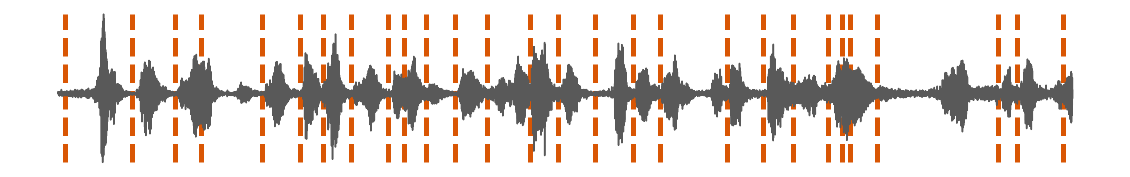

50550
50550


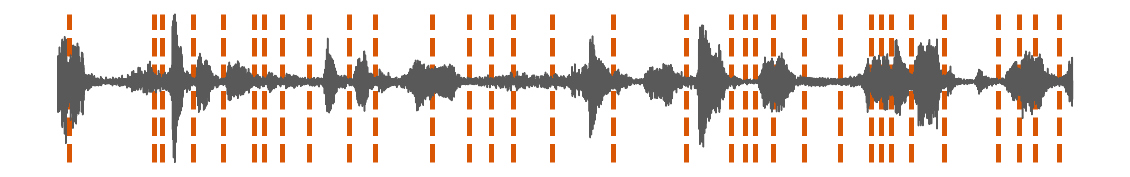

101350
101350


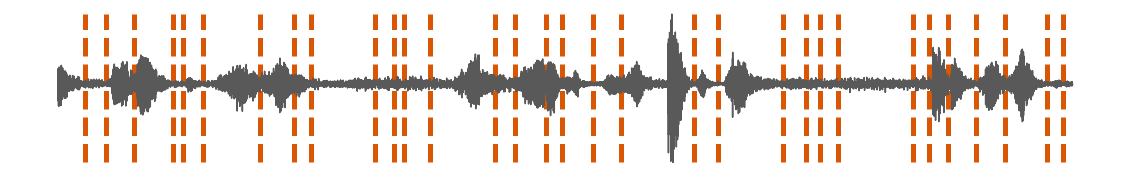

151450
151450


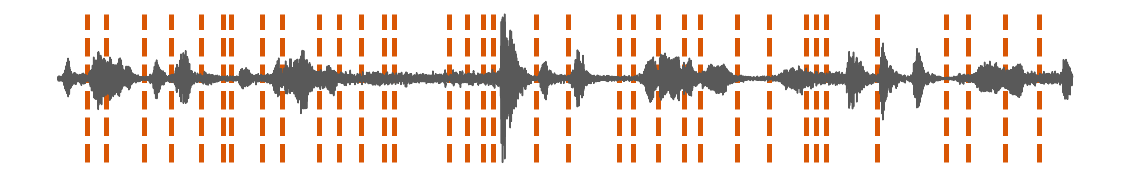

203350
203350


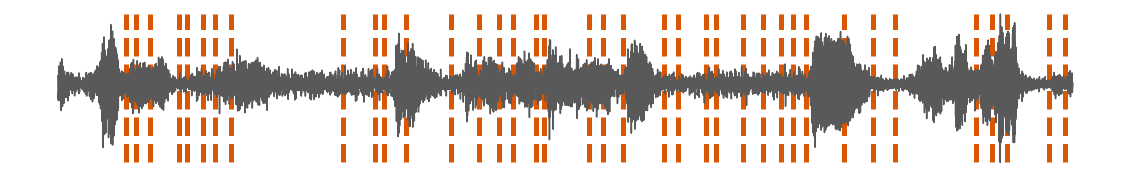

250550
250550


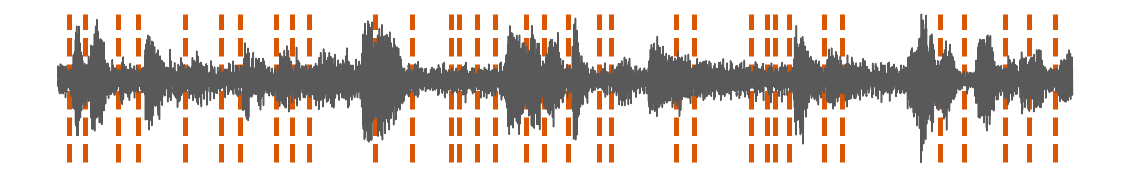

300950
300950


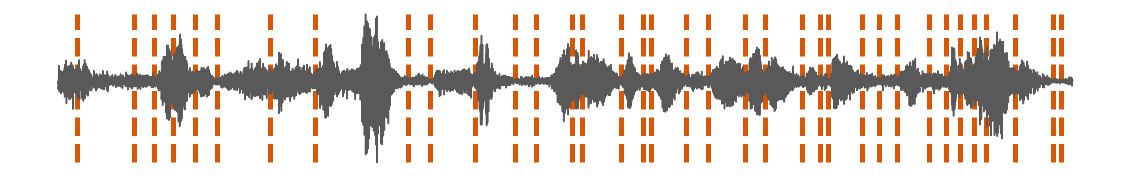

352150
352150


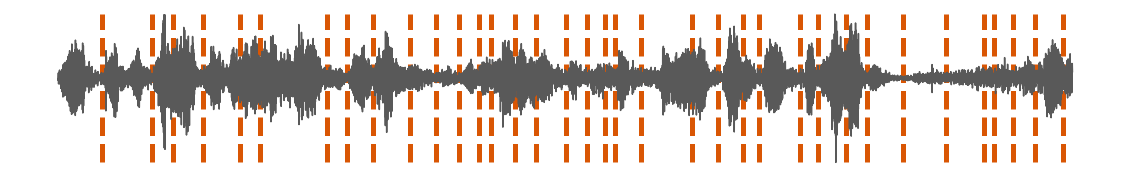

400750
400750


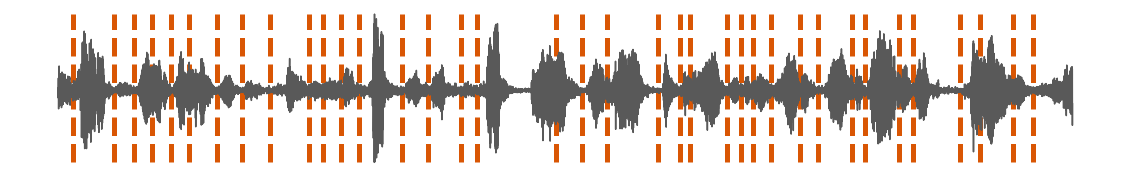

453650
453650


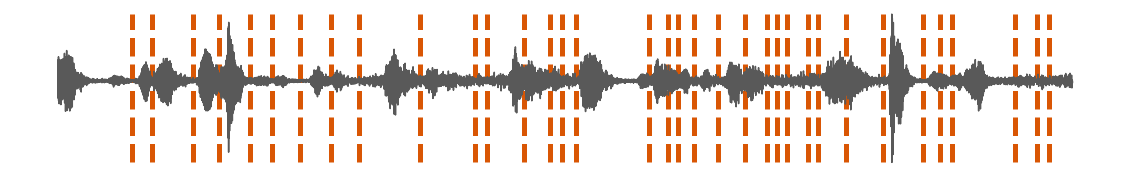

501150
501150


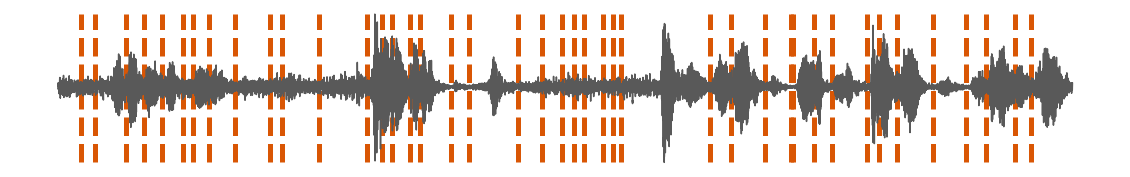

550950
550950


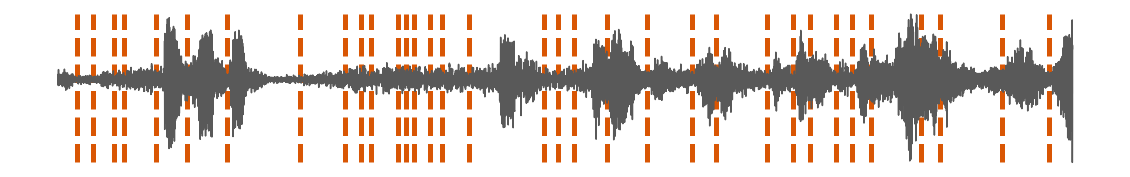

600850
600850


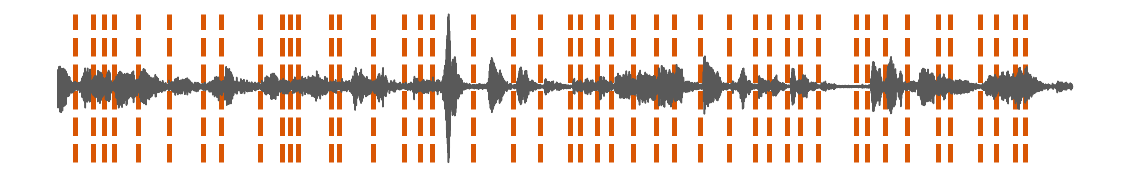

650650
650650


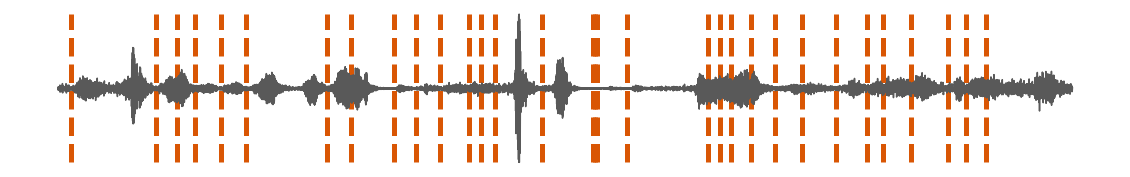

702450
702450


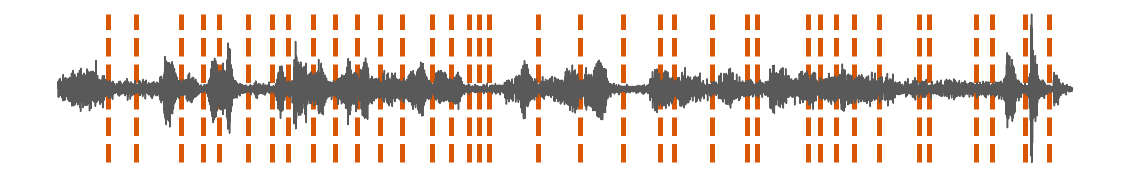

750850
750850


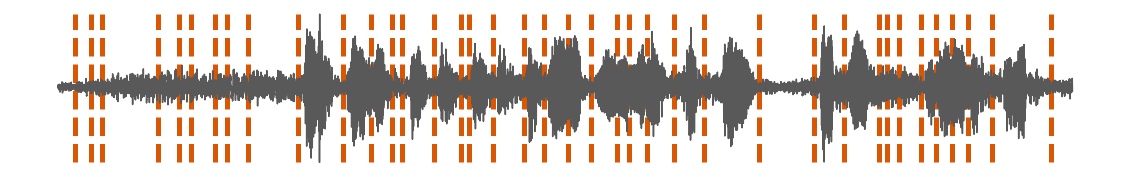

801550
801550


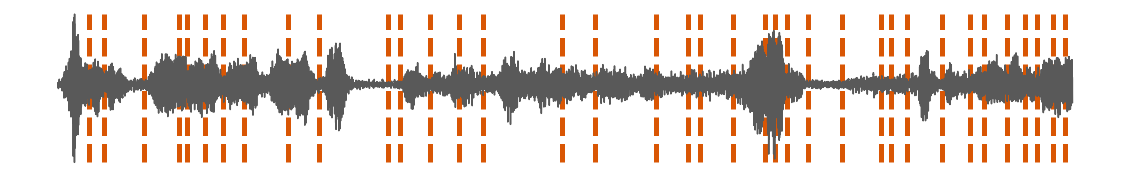

851650
851650


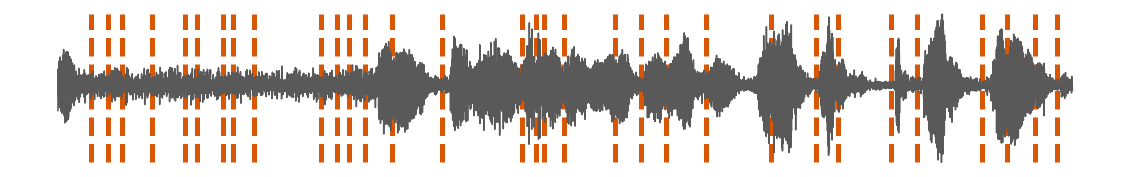

900650
900650


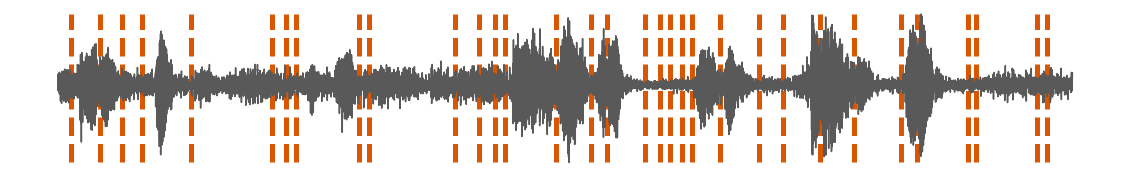

950550
950550


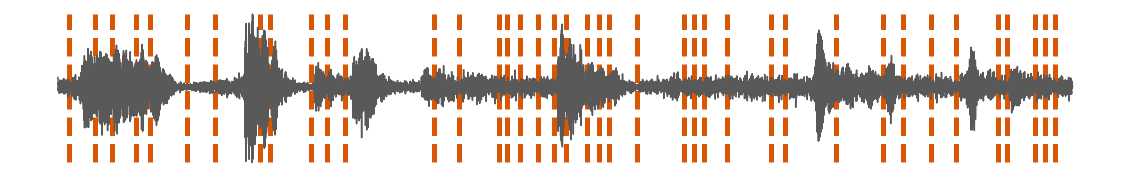

1000550
1000550


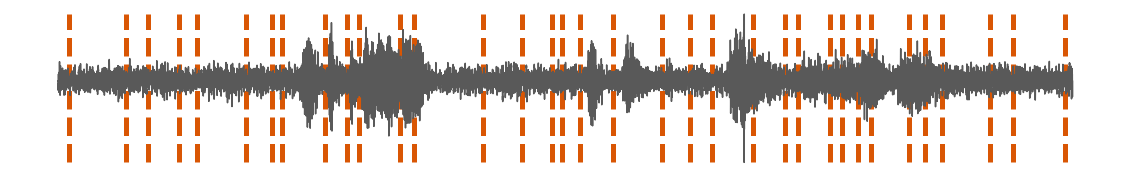

1051050
1051050


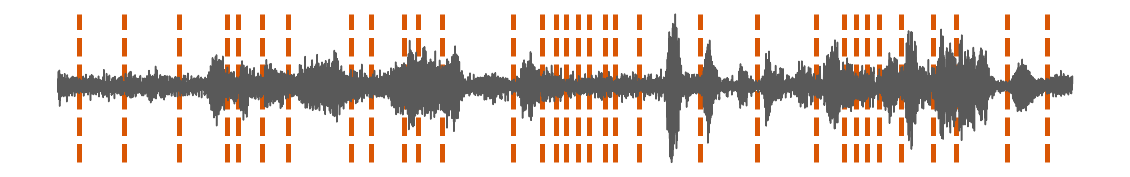

1101150
1101150


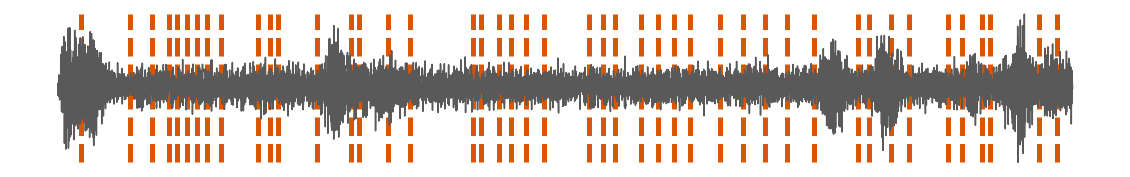

1151050
1151050


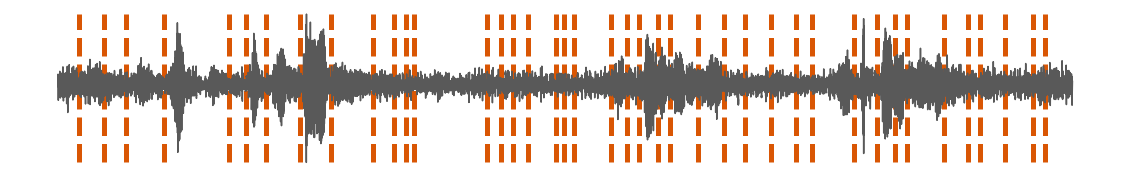

1200550
1200550


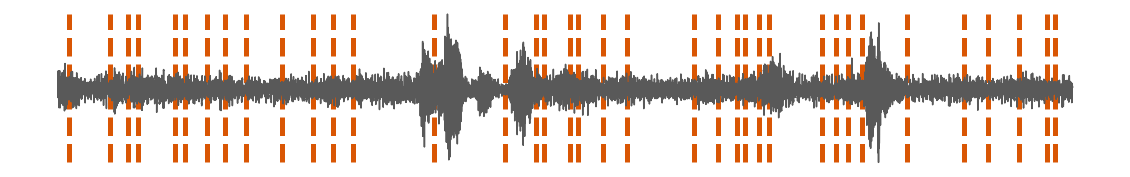

1250750
1250750


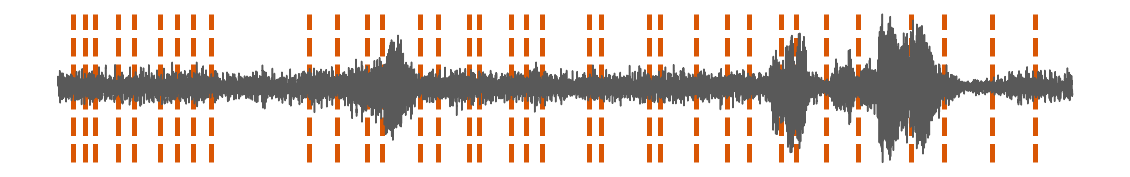

1301150
1301150


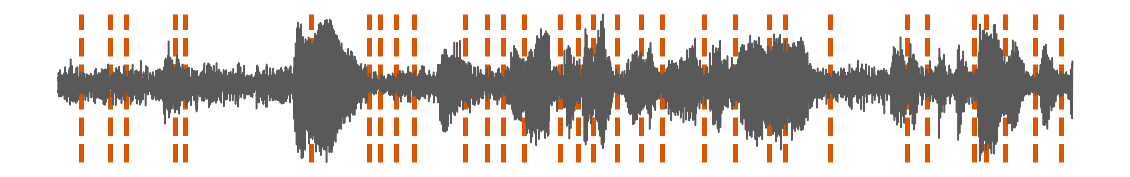

1352350
1352350


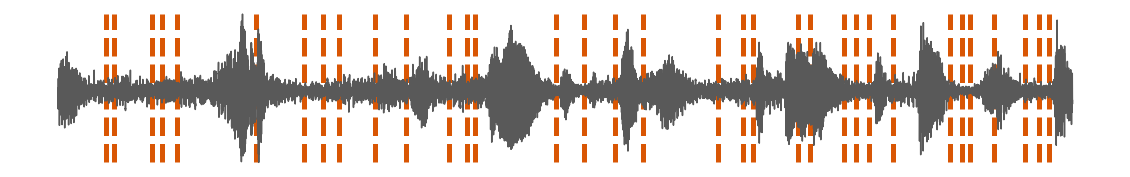

1401850
1401850


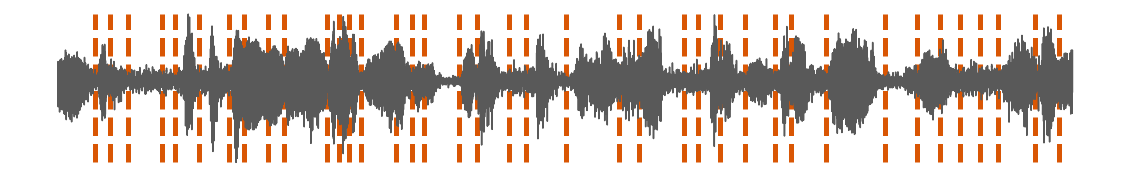

1450850
1450850


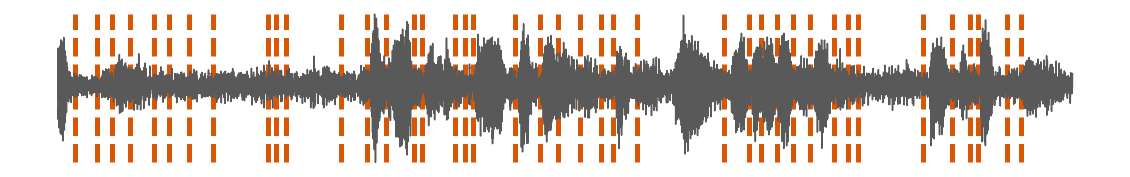

1500450
1500450


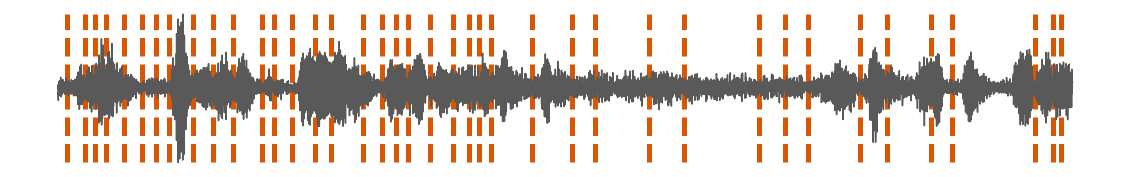

1550350
1550350


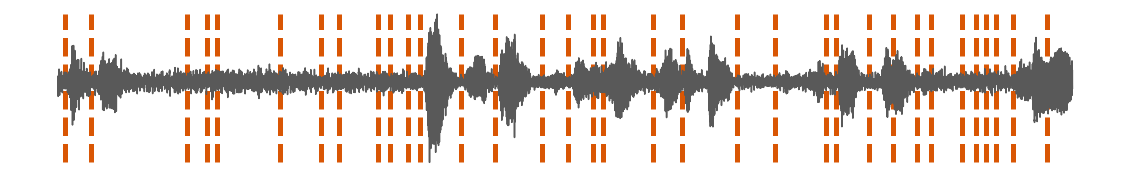

1601050
1601050


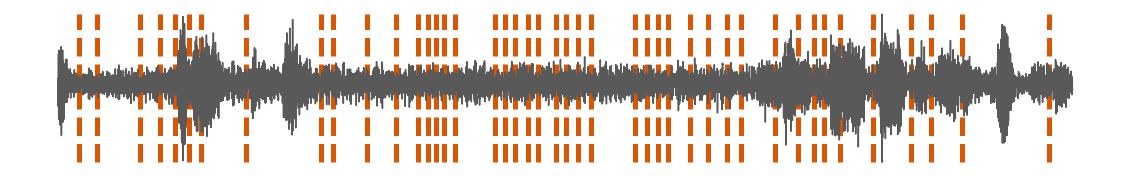

1651050
1651050


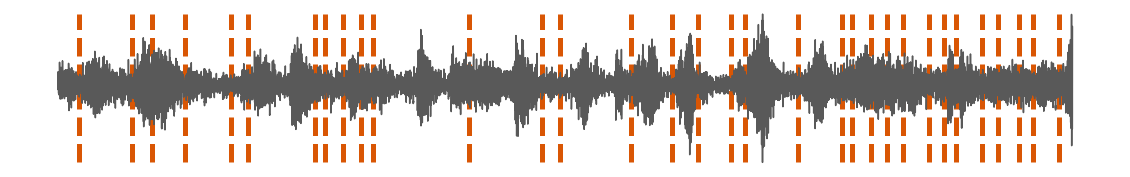

1701850
1701850


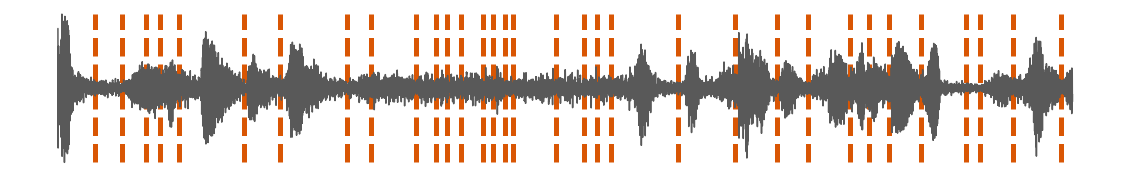

1750550
1750550


KeyboardInterrupt: ignored

In [ ]:
all_pred_bounds = []
X_pred = []
indicies = []

n = 50000
for i in range(int(np.floor(len(audio_array)/n))):
  
  vals = audio_array[n*i:n*(i+1)]
  potential_bounds = []
  ser = moving_average(np.abs(vals),300)[::100]
  for j,x in enumerate(ser):
    if (j>1)&(j<len(ser)-2):
      if (x<ser[j-1]<ser[j-2]) & (x<ser[j+1]<ser[j+2]):
        potential_bounds.append(j)
      elif (x < .003):
        potential_bounds.append(j)
  potential_bounds = np.array(potential_bounds)
  print(potential_bounds[0]*100+n*i+150)
  m_index = []
  for j,v in enumerate(potential_bounds):
    try:
      if v - potential_bounds[j-1] == 1:
        if potential_bounds[j+1]-v == 1:
          m_index.append(j)
    except IndexError:
      pass

  # mask = np.ones(len(potential_bounds), dtype=bool)
  # mask[m_index] = False
  potential_bounds = (potential_bounds)*100+n*i+150
  print(potential_bounds[0])
  plt.plot(range(n*i,n*(i+1)),vals,color='#595959')
  plt.vlines(potential_bounds,np.min(vals),np.max(vals),color='#d95604',linewidth=5.0,linestyles='--')
  
  plt.axis('off')
  
  plt.show()

  all_pred_bounds += list(set(potential_bounds))


# for p_b in all_pred_bounds:
#   if p_b > 25600:
#     try:
#       MFCC = librosa.feature.mfcc(audio_array[p_b-25600:p_b-1], n_mfcc = 15, hop_length=128)
#       if MFCC.shape == (15,200):
#         X_pred.append(MFCC)
#         indicies.append(p_b)
#       else:
#         print('incorrect shape')
#     except:
#       pass

In [ ]:
X_pred = np.array(X_pred)

In [ ]:
X_pred.shape

(960, 15, 200)

In [ ]:
preds = [i for i,x in enumerate(model.predict(X_pred)) if round(x[0]) == 1]

In [ ]:
predicted_bounds = np.array(indicies)[preds]/8000

In [ ]:
predicted_bounds.sort()

In [ ]:
all_pred_bounds

[1397250,
 1367050,
 1386250,
 1371150,
 1390350,
 1361950,
 1382950,
 1378350,
 1384750,
 1387950,
 1360050,
 1353650,
 1374650,
 1373250,
 1376450,
 1379650,
 1350350,
 1369550,
 1399550,
 1368150,
 1364450,
 1355750,
 1363050,
 1366250,
 1388650,
 1389050,
 1357050,
 1396350,
 1643650,
 1604750,
 1614350,
 1636750,
 1646350,
 1618450,
 1638550,
 1648150,
 1620250,
 1605150,
 1624350,
 1615650,
 1600550,
 1610150,
 1611050,
 1634350,
 1609650,
 1622450,
 1635250,
 1633850,
 1612350,
 1642050,
 1649350,
 1608150,
 1627350,
 1641050,
 1621350,
 1630950,
 1640550,
 1640050,
 1647350,
 1606650,
 1633150,
 1559950,
 1577750,
 1576350,
 1557150,
 1598750,
 1574050,
 1586850,
 1581350,
 1561650,
 1556150,
 1599550,
 1555650,
 1574850,
 1572550,
 1567050,
 1562450,
 1565650,
 1553750,
 1566550,
 1582550,
 1585750,
 1592150,
 1568350,
 1571550,
 1552350,
 1587550,
 1588450,
 1596650,
 1595250,
 1551350,
 1592950,
 1593850,
 1708550,
 1714950,
 1737350,
 1743750,
 1735050,
 1729550,
 1736850,


In [ ]:
import datetime


'0:11:06'

In [ ]:
[str(datetime.timedelta(seconds=x)) for x in predicted_bounds]

['0:02:50.556250',
 '0:02:54.943750',
 '0:03:13.893750',
 '0:03:13.918750',
 '0:03:15.368750',
 '0:03:16.256250',
 '0:03:16.281250',
 '0:03:16.568750',
 '0:03:16.606250',
 '0:03:16.618750',
 '0:03:17.468750',
 '0:03:18.331250',
 '0:03:18.556250',
 '0:03:18.556250',
 '0:03:19.106250',
 '0:03:19.118750',
 '0:03:19.443750',
 '0:03:21.143750',
 '0:03:21.793750',
 '0:03:21.868750',
 '0:03:22.368750',
 '0:03:22.393750',
 '0:03:23.406250',
 '0:03:23.418750',
 '0:03:23.431250',
 '0:03:26.981250',
 '0:03:27.868750',
 '0:03:27.881250',
 '0:03:28.818750',
 '0:03:32.868750',
 '0:03:32.893750',
 '0:03:32.918750',
 '0:03:33.381250',
 '0:03:34.218750',
 '0:03:34.231250',
 '0:03:39.456250',
 '0:03:39.456250',
 '0:03:39.593750',
 '0:03:40.531250',
 '0:03:42.118750',
 '0:03:42.181250',
 '0:03:42.218750',
 '0:03:45.481250',
 '0:03:45.981250',
 '0:03:46.543750',
 '0:03:46.568750',
 '0:03:46.568750',
 '0:03:46.606250',
 '0:03:47.593750',
 '0:03:47.618750',
 '0:03:49.756250',
 '0:03:51.818750',
 '0:03:53.25